
# Attribution 

When inspecting the impact of experiments it is very useful to be able to analyze which input changes drives the impact. Also for a specific simulation it can be useful to analyze which input changes drives the year to year changes. 

Modelflow has some tools to automate this process and to visualize the impact. This chapter gives an introduction to the concept 'attribution' and demonstrates how Modelflow's built-in functionalities help you explore and understand your results and which variables drive the change. 


## Setup 
This class incorporates most of the methods used to manage a model. 

In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

In [2]:
# Modules from Modelflow 
from modelclass import model 

# optional functionalities 
model.widescreen()
model.scroll_off()

# Output compatabiltity with LaTeX 
latex=False

In [3]:
 %load_ext autoreload
 %autoreload 2

## Load a pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions: 

 - Loads model and simulates to establish a baseline.
 - Creates a dataframe with a tax rate of 29 USD/Ton for carbon emission for 3 sectors.
 - Simulates the new experiment. 
 
 You can find more on this experiment [here](../experiments/create_experiment.ipynb)

In [4]:
mpak,baseline = model.modelload('../../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
alternative  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 29")
result = mpak(alternative,2020,2100,keep='Carbon tax nominal 29') # simulates the model 

file read:  C:\modelflow manual\working_paper\thebook\content\models\pak.pcim


(attribution)=
## Attribution 

Experience shows that it is useful to be able to explain the difference between the result from two runs, or between two time periods.
 - The first level of understanding the difference is to look at selected formulas and find out, how much each input variables accounts for. 
 - The second level of understanding the difference is to look at the attribution of the 
exogenous variables to the results of the model.  

If we have:

$y = f(a,b)$

and we have two solutions where the variables differs by $\Delta y, \Delta a, \Delta b$

How much of $\Delta y$ can be explained by $\Delta a$ and $\Delta b$ ?

Analytical the attributions $\Omega a$ and $\Omega b$ can  be calculated like this: 

$\Delta y = \underbrace{\Delta a \dfrac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \dfrac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

ModelFlow will do a numerical approximation of $\Omega a$ and $\Omega b$. This is done by looking at the two runs of the model:

\begin{eqnarray}  
y_0&=&f(a_{0},b_{0}) \\
y_1&=&f(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

So $\Omega a$ and $\Omega b$ can be determined:

\begin{eqnarray}  
\Omega f_a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega f_b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



And: 

\begin{eqnarray}
residual = \Omega f_a + \Omega f_b -(y_1 - y_0) 
\end{eqnarray}
If the model is fairly linear, the residual will be small. 



## Which function: Model attribution or  single equation attribution?

To recap. Above we just used the term $f$ for the function. $f$ can actually be two different types of functions. 
 - The complete model<br>In this case the $\Delta a$,$\Delta b$ ... can be different exogenous variables. 
 - A single equation <br>In this case the $\Delta a$,$\Delta b$ ... can be all the current and lagged variables on the right hand side of the = in the equation  
 
 Examples will be given below. 

## Which output?

Let's pretend we only have two variables $a$ and $b$: 

- Absolute levels:  $\Omega a$ and $\Omega b$ ...
- Relative impact in percent:  $\cfrac{100*\Omega a}{\Delta y}$  $\cfrac{100*\Omega b}{\Delta y}$
- Impact on the growth rate of $y$ from  $a$ and $b$

## Which input?
What exactly is $\Delta a$ and $\Delta b$? There are two possibilities: 

1. The difference between the two scenarios in .basedf and .lastdf
2. The difference over time: $\Delta a = a_t - a_{t-1}$ and $\Delta b = b_t - b_{t-1}$ taken from .lastdf



## .totdif() Makes an instance of a  model attribution class
.totdif() returns a class instance of the totdif class. The totdif class contains a number of 
methods and properties which can slice and dice attribution at the model level.<br> Without any parameters it 
takes all changed exogenous variables and finds the attribution from each of these.

To do this it simulates the model a number of times. So If many exogenous differ this can take some time. 

In [5]:
totdekomp = mpak.totdif()

Total dekomp took       :         2.986 Seconds


### .explain_all will visualize the results

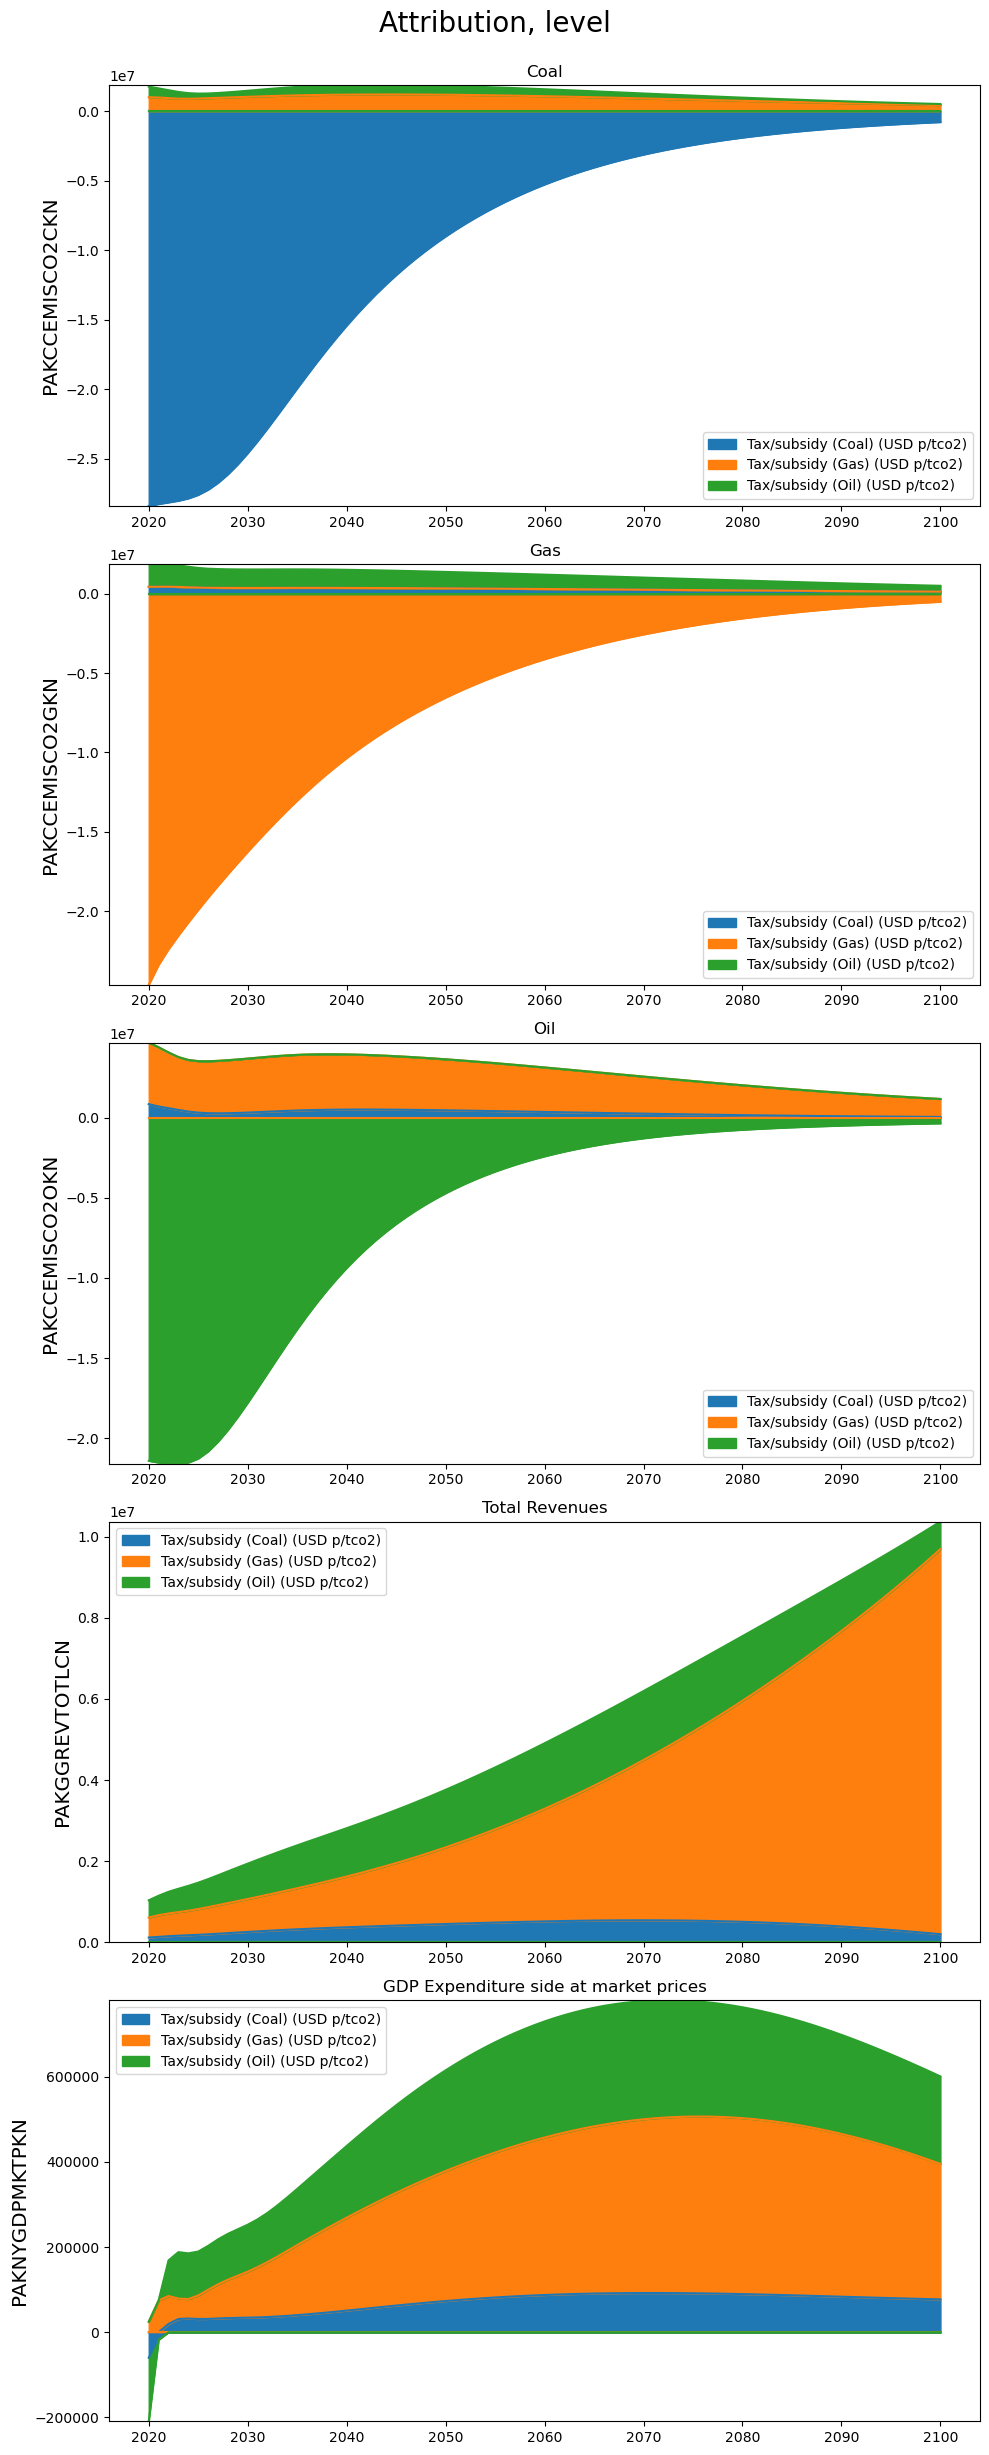

In [6]:
showvar = 'PAKNYGDPMKTPKN PAKCCEMISCO2CKN PAKCCEMISCO2OKN PAKCCEMISCO2GKN PAKGGREVTOTLCN'
totdekomp.explain_all(showvar,kind='area',stacked=True,top=0.95);    


### Or we can use interactive widgets
This allows the user to select the specific variable of interest and what to display: 


:::{note}
If this is read in a manual the widget is not live. 

In a notebook the selection widgets are live. 
:::


In [7]:
display(mpak.get_att_gui(var='PAKGGREVTOTLCN',ysize=7));

interactive(children=(Dropdown(description='Variable', index=108, options=('CHNEXR05', 'CHNPCEXN05', 'DEUEXR05…

None

When the results are displayed, they can be filtered, sliced and diced in a number of ways. 

### More advanced model attribution

For some  models (like the EBA bank stress test model) the number of changed exogenous variables can be large. Using a dictionary to contain the experiments allows us to create experiments where all variables for each country are analyzed, or each macro variable for all countries are analyzed. 

Also it is possible to use aggregated sums - useful for looking at impact on PD's. Or just the last time period - useful for looking at CET1 ratios. 

If there are many experiments, data can be filtered in order to look only at the variables with an impact above a certain threshold. 

The is also the possibility to   anonymize  the row and column names and to randomize
the order of rows and/or columns - useful for bank names. 

## Formula attribution
Attribution analysis on the formula level is performed by the method **.dekomp**. 

This method utilizes that two attributes .basedf and .lastdf containing the first and the last run are contained in the model instance. Also all the formulas are contained in the instance. Therefore a model, just with one formula - is created. Then experiments mentioned above is run for each period and each right hand side variable. 

### Single equation attribution output

In [8]:
with mpak.set_smpl(2020,2025):
    mpak['PAKCCEMISCO2TKN'].dekomp()


Formula        : FRML  <> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $ 

                        2020         2021         2022         2023         2024         2025
Variable    lag                                                                              
Base        0   216055772.84 222601656.91 230049529.33 238103197.33 246127123.55 253659456.66
Alternative 0   153705842.11 160634232.91 168319944.42 176432099.88 184790573.07 193170252.17
Difference  0   -62349930.73 -61967424.00 -61729584.91 -61671097.45 -61336550.48 -60489204.50
Percent     0         -28.86       -27.84       -26.83       -25.90       -24.92       -23.85

 Contributions to differende for  PAKCCEMISCO2TKN
                            2020         2021         2022         2023         2024         2025
Variable        lag                                                                              
PAKCCEMISCO2CKN 0   -24768096.25 -25017497.26 -25248615.93 -25456453.36 -25531990.77 -254140

### Single equation attribution chart 
The results can be visualized in different ways. 

In [9]:
help(mpak.dekomp_plot)

Help on method dekomp_plot in module modelclass:

dekomp_plot(varnavn, sort=True, pct=True, per='', top=0.9, threshold=0.0, lag=True, rename=True, nametrans=<function Dekomp_Mixin.<lambda> at 0x00000228946264C0>, time_att=False) method of modelclass.model instance
    Returns  a chart with attribution for a variable over the smpl  
    
    Parameters
    ----------
    varnavn : TYPE
        variable name.
    sort : TYPE, optional
        . The default is False.
    pct : TYPE, optional
        display pct contribution . The default is True.
    per : TYPE, optional
        DESCRIPTION. The default is ''.
    threshold : TYPE, optional
        cutoff. The default is 0.0.
    rename : TYPE, optional
        Use descriptions instead of variable names. The default is True.
    time_att : TYPE, optional
        Do time attribution . The default is False.
    lag : TYPE, optional
       separete by lags The default is True.           
    top : TYPE, optional
      where to place the titl

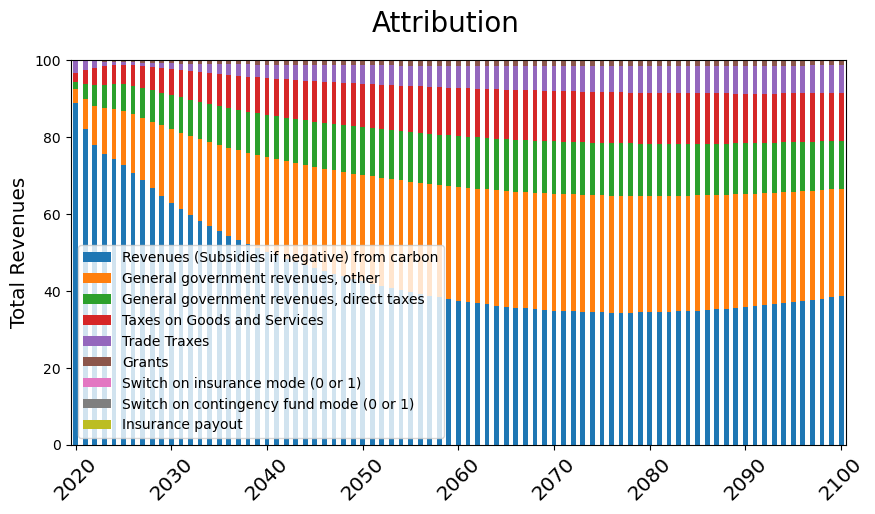

In [10]:
mpak.dekomp_plot('PAKGGREVTOTLCN',pct=1);

### Chart in pct of the total 

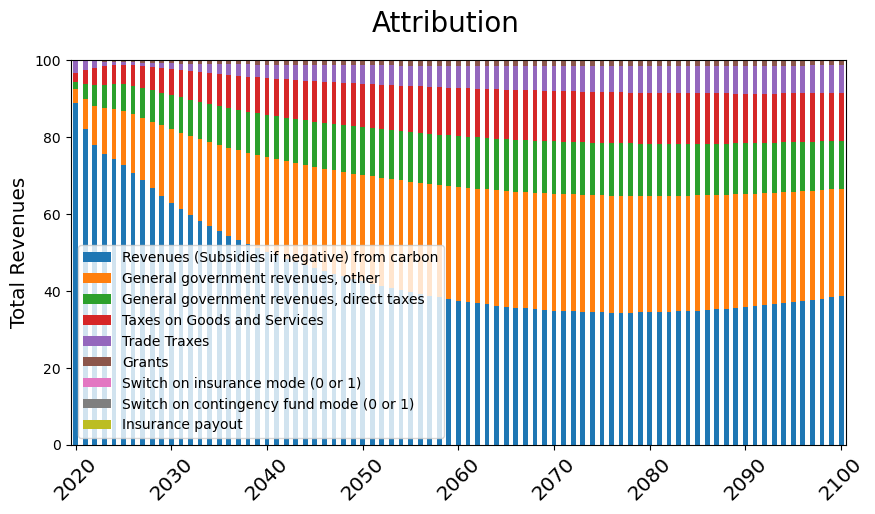

In [11]:
mpak.dekomp_plot('PAKGGREVTOTLCN',rename=1);

### Chart for one year 
The attribution for one year can be dispalyed in a waterfall chart. 

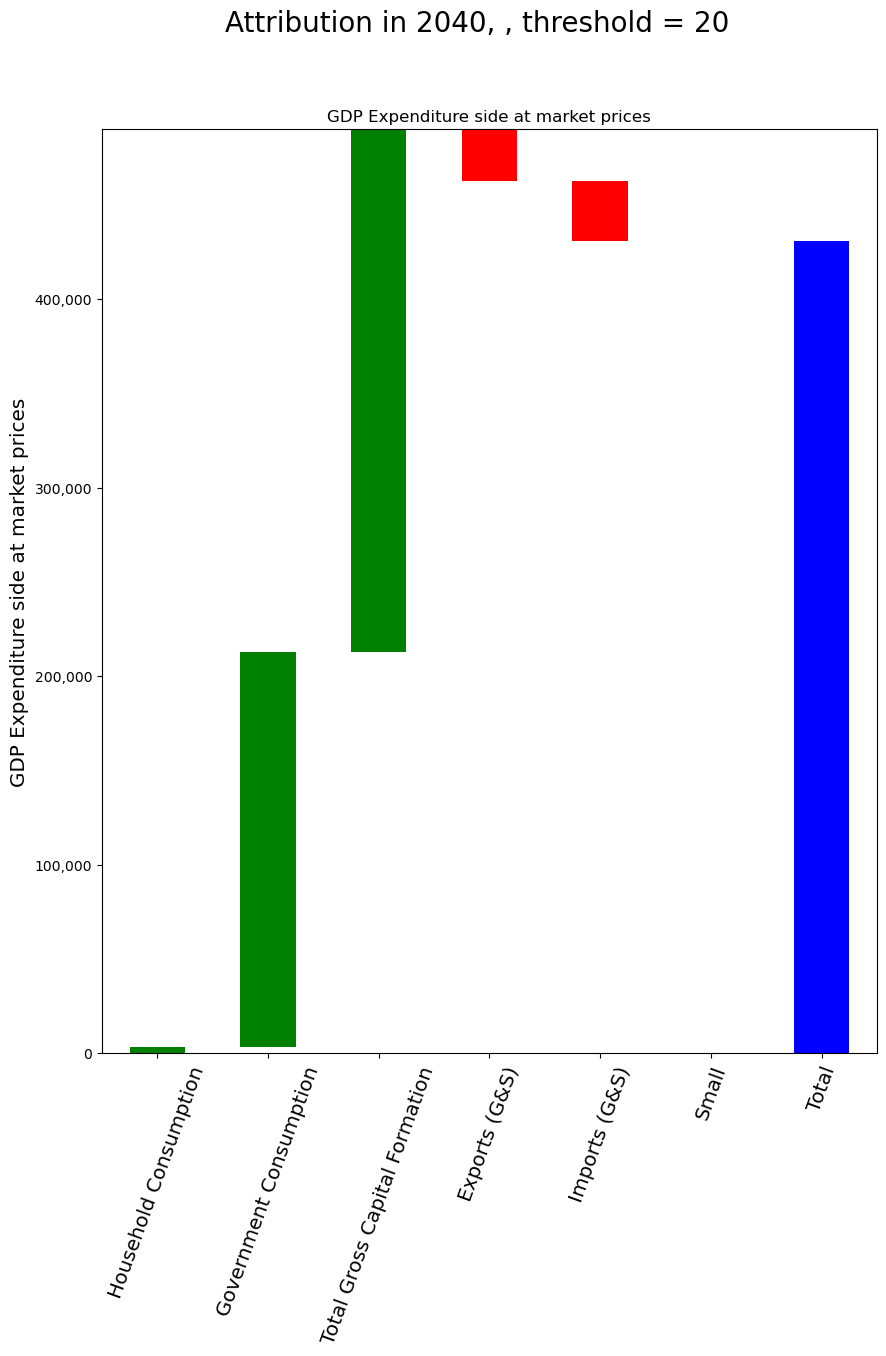

In [12]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,rename=1,pct=0,ysize=12,threshold =20);

### Sorting of attribution

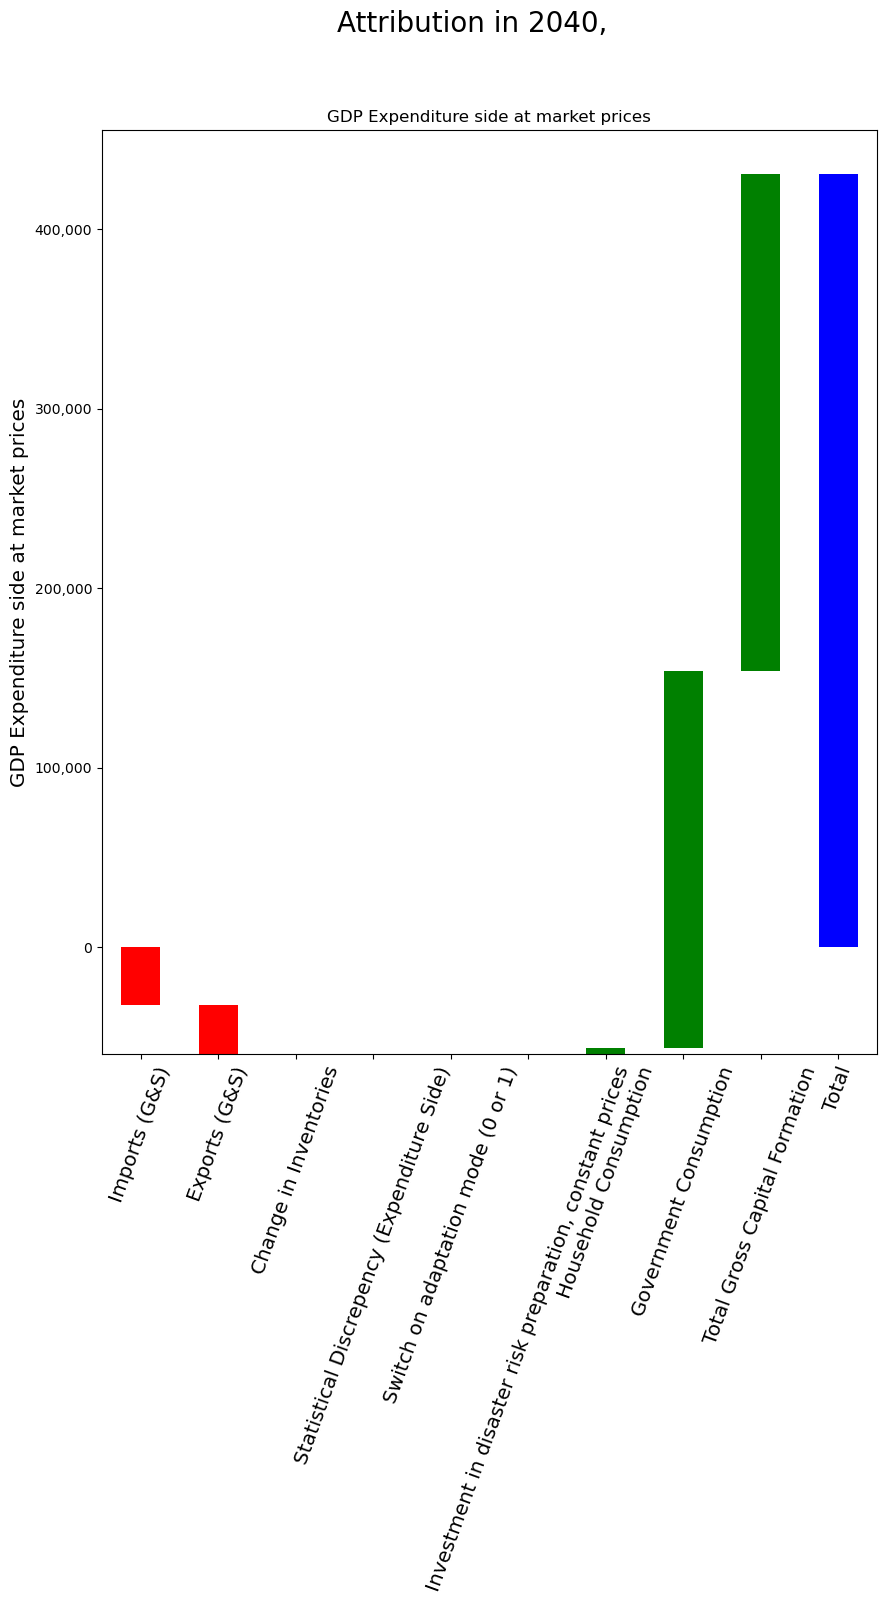

In [13]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,ysize=12);

### Truncate attribution
Some equations have a lot of small contributions. These can be aggregated through the ```threshold=<some number>``` parameter. 
Variables for which all contributions are below the threshold will be lumped together in the **small** bin. Like below:

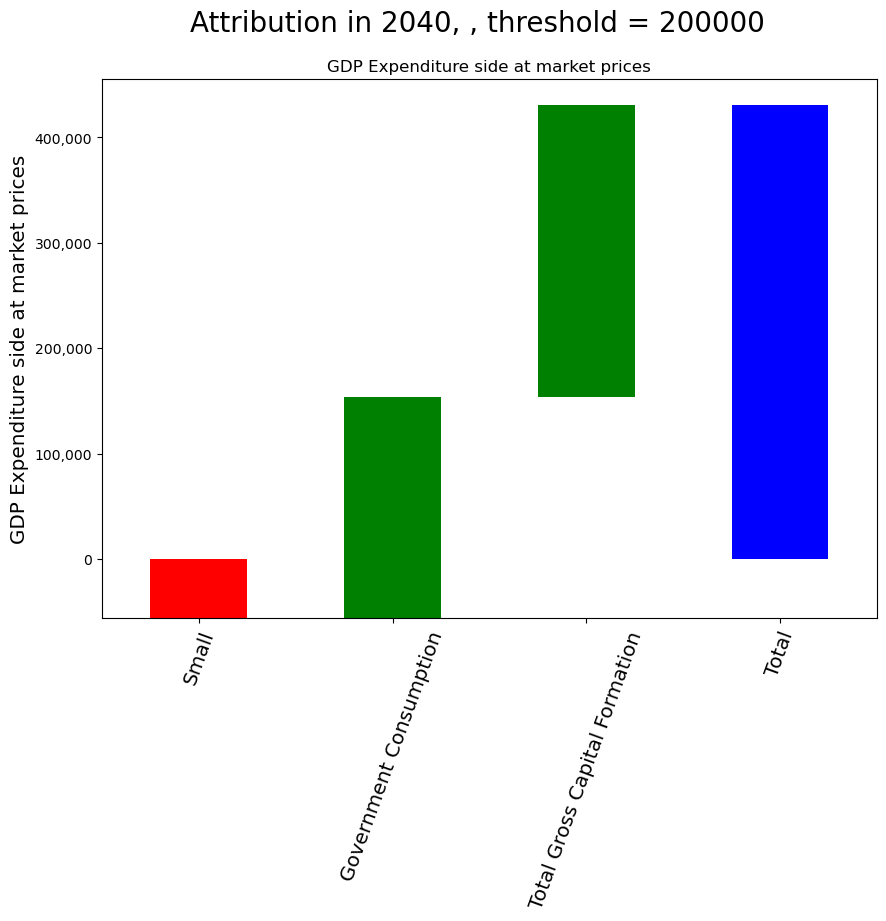

In [14]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,threshold =200000,ysize=7);

### Attribution when comparing time frames 
In this case we seek to find out which variables explains the development from year to year. This is done only for the .lastdf dateframe. 

In [15]:
with mpak.set_smpl(2020,2024):
    mpak['PAKNYGDPMKTPKN'].dekomp(time_att=True)


Formula        : FRML  <> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $ 

                      2020        2021        2022        2023        2024
Variable   lag                                                            
t-1        0   26155676.78 26483175.56 27235594.39 27963320.84 28690715.60
t          0   26483175.56 27235594.39 27963320.84 28690715.60 29445700.45
Difference 0     327498.79   752418.82   727726.46   727394.76   754984.85
Percent    0          1.25        2.84        2.67        2.60        2.63

 Contributions to differende for  PAKNYGDPMKTPKN
                         2020       2021       2022       2023       2024
Variable       lag                                                       
PAKNECONPRVTKN 0    -13865.31  628033.34  630618.85  606862.06  603453.77
PAKNECONGOVTKN 0    308028.31   98561.83   70113.20   89705.17  116556.97
PAKNEGDIFTOTKN 0    225172.56 

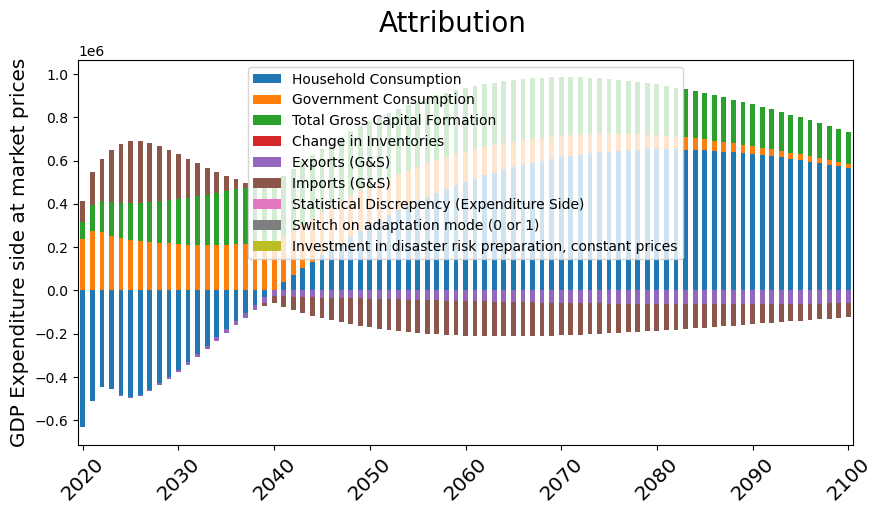

In [16]:
mpak.dekomp_plot('PAKNYGDPMKTPKN',pct=0,rename=1,sort=1,threshold =0,time_att = True);

### Visualizing attribution in dependency graphs
The logical graph of the model can be used to show the upstream and downstream variable for a specific variable. More on this [here](../structure/Logical_structure.ipynb)<br>
When drawing the logical graph for a variable the model attribution will be used to guide the thickness of edges between nodes (variables). This enables a visual impression of which 
variables drives the impact. 

::: {note}
If png == 0 the graph below will be rendered in SVG format. This enables tooltips with additional information when the mouse hovers 
over an edge or an node. 

Unfortunately svg can't be displayed in the manual, so png has to be True for the manual. In a live jupyter notebook set latex=0. This will 
enable svg format. 
:::

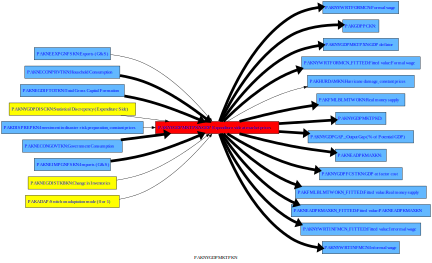

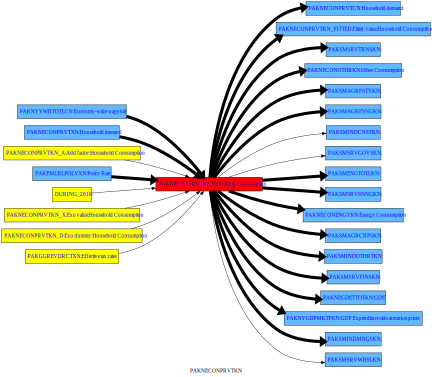

In [17]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1,png=latex)  # diagram all direct dependencies 

### The attribution can be filtered and more levels can be displayed. 

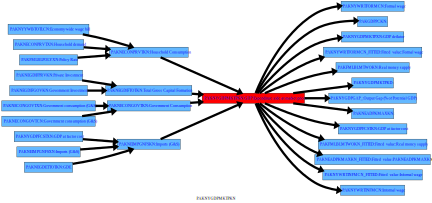

In [18]:
mpak['PAKNYGDPMKTPKN'].draw(up=2,down=1,png=latex,filter=20) 

### Or it can be used in a dashboard (not avaiable in the offline manual) 

In [ ]:
try:
    mpak.modeldash('PAKNYGDPMKTPKN',jupyter=1,inline=False)
except: 
    print('No Dashboard installed')

apprun
